# İçerik

<ol>
    <li><strong>Kurulum ve İçe Aktarmalar (Setup and Imports)</strong></li>
    <li><strong>Yapılandırma (Configuration)</strong></li>
    <li><strong>Tekrar Edilebilirlik (Reproducibility)</strong></li>
    <li>
        <strong>Veri Seti</strong>
        <ol>
            <li>Meta Data</li>
        </ol>
    </li>
    <li>
        <strong>Keşif Amaçlı Veri Analizi (Exploratory Data Analysis - EDA)</strong>
        <ol>
            <li>Hedef Özellik: öbek_ismi</li>
            <li>Kategorik özelliklerin kendi içinde dağılımı</li>
            <li>Sayısal Özellikler</li>
        </ol>
    </li>
    <li>
        <strong>Feature Engineering (Özellik Mühendisliği)</strong>
        <ol>
            <li>Yeni Özellik: alım_oranı</li>
            <li>Yeni Özellik: gelir_grubu</li>
            <li>Yeni Özellik: ortalama_ödeme</li>
            <li>Yeni Özellik: satın_alma_etkinliği</li>
        </ol>
    </li>
    <li>
        <strong>Veri Ön İşleme (Data Preprocessing)</strong>
        <ol>
            <li>Log Transform</li>
            <li>Encoding ve Standartlaştırma</li>
            <li>Yeni Özellik: müşteri_kimliği (PCA)</li>
            <li>Yeni Özellik: müşteri_kümeleri (Soft Clustering)</li>
        </ol>
    </li>
    <li><strong>Özellik Seçimi (Feature Importance and Selecting)</strong></li>
    <li>
        <strong>Modelleri Oluşturma ve Geliştirme</strong>
        <ol>
            <li>Doğrulama ve eğitim setini ayırma</li>
            <li>Veri Arttırma (Data Augmentation)</li>
            <li>Makine Öğrenmesi Modelleri</li>
            <li>Derin Öğrenme Modelleri</li>
        </ol>
    </li>
    <li><strong>Sonuçları Oluşturma (Inference)</strong></li>
    <li><strong>Referanslar</strong></li>
</ol>

# 1. Kurulum ve İçe Aktarmalar (Setup and Imports)

In [1]:
import warnings
warnings.filterwarnings('ignore')  # Uyarıları görmezden gel

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Bilimsel hesaplamalar ve istatistiksel işlemler için
from scipy.stats import skew

# Veri kümeleme ve boyut indirgeme için
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Veri ön işleme ve modelleme için
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

# Makine öğrenimi modelleri
import xgboost
import catboost
import lightgbm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

# Derin öğrenme kütüphaneleri
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# Görselleştirmeler için varsayılan stil ayarı
sns.set(style="ticks", rc={"axes.spines.top": False, "axes.spines.right": False})

# 2. Yapılandırma (Configuration) 

In [2]:
class Config:
    # Rastgele sayı üreteçleri için sabit değer
    SEED = 42

    # Veri setinin bulunduğu temel dizin yolu
    BASE_PATH = "/kaggle/input/datathon2023/"

    # Kategorik özelliklerin sütun adları
    CATEGORICAL_COLUMNS = [
        "cinsiyet", "yaş_grubu", "medeni_durum", "eğitim_düzeyi",
        "i̇stihdam_durumu", "yaşadığı_şehir", "en_çok_i̇lgilendiği_ürün_grubu",
        "eğitime_devam_etme_durumu", "öbek_i̇smi", "gelir_grubu"
    ]

    # Sayısal özelliklerin sütun adları
    NUMERIC_COLUMNS = [
        "yıllık_ortalama_gelir", "yıllık_ortalama_satın_alım_miktarı",
        "yıllık_ortalama_sipariş_verilen_ürün_adedi",
        "yıllık_ortalama_sepete_atılan_ürün_adedi", "alım_oranı",
        "ortalama_ödeme", "satın_alma_etkinliği"
    ]

# Yapılandırma sınıfının bir örneği oluşturma
config = Config()

# 3. Tekrar edilebilirlik (Reproducibility)

In [3]:
# NumPy rastgele sayı üreteci için tohum ayarı
np.random.seed(config.SEED)

# Pandas'ın rastgele sayı üreteci için tohum ayarı
pd.np.random.seed(config.SEED)

# Keras rastgele sayı üreteci için tohum ayarı
keras.utils.set_random_seed(seed=config.SEED)

# 4. Veri Seti

In [4]:
# Eğitim veri setini okuma
df_train = pd.read_csv(f"{config.BASE_PATH}train.csv")

# Test veri setini okuma
df_test = pd.read_csv(f"{config.BASE_PATH}test_x.csv")

In [5]:
df_train.head()

,index,Cinsiyet,Yaş Grubu,Medeni Durum,Eğitim Düzeyi,İstihdam Durumu,Yıllık Ortalama Gelir,Yaşadığı Şehir,En Çok İlgilendiği Ürün Grubu,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Eğitime Devam Etme Durumu,Öbek İsmi,Yıllık Ortalama Sepete Atılan Ürün Adedi
0,0,Kadın,31-40,Bekar,Yüksek Lisans Mezunu,Düzenli ve Ücretli Bir İşi Var,748266.440879,Büyük Şehir,Elektronik ve Teknolojik Ürünler,32010.900881,37.310644,Etmiyor,obek_4,102.936904
1,1,Erkek,>60,Evli,Lise Mezunu,Kendi İşinin Sahibi,246298.609605,Küçük Şehir,Spor Malzemeleri,4145.729891,11.554851,Etmiyor,obek_5,82.176053
2,2,Erkek,18-30,Bekar,Lise Mezunu,Düzenli ve Ücretli Bir İşi Var,268582.732360,Küçük Şehir,Giyim,9924.379414,55.353236,Ediyor,obek_8,141.661426
3,3,Erkek,51-60,Evli,Lise Mezunu,Kendi İşinin Sahibi,327721.837865,Kırsal,Giyim,6417.780714,15.417239,Etmiyor,obek_3,17.097397
4,4,Erkek,31-40,Evli,Ortaokul Mezunu,İşsiz veya Düzenli Bir İşi Yok,397431.626948,Büyük Şehir,Giyim,7886.663061,14.689837,Etmiyor,obek_3,20.470459


## 1. Meta Data

- **İndex:** Her birey için benzersiz tanımlayıcı numara.
- **Cinsiyet:** Bireyin cinsiyet bilgisi.
- **Yaş Grubu:** Bireyin yaş aralığı (örn. 18-30, 31-40, vb.).
- **Medeni Durum:** Bireyin medeni durumu (Evli, Bekar).
- **Eğitim Düzeyi:** Bireyin en yüksek eğitim seviyesi.
- **İstihdam Durumu:** Bireyin çalışma durumu (örn. Emekli, İşsiz, vb.).
- **Yıllık Ortalama Gelir:** Bireyin yıllık ortalama geliri.
- **Yaşadığı Şehir:** Bireyin yaşadığı şehir veya bölge türü.
- **En Çok İlgilendiği Ürün Grubu:** Bireyin ilgi duyduğu veya sıklıkla satın aldığı ürün kategorisi.
- **Yıllık Ortalama Satın Alım Miktarı:** Bireyin yıllık ortalama satın aldığı ürün miktarı.
- **Yıllık Ortalama Sipariş Verilen Ürün Adedi:** Bireyin yıllık ortalama sipariş verdiği ürün sayısı.
- **Eğitime Devam Etme Durumu:** Bireyin eğitime devam etme durumu (örn. Devam Ediyor, Devam Etmiyor, vb.).
- **Yıllık Ortalama Sepete Atılan Ürün Adedi:** Bireyin yıllık ortalama sepete attığı ürün sayısı.
- **Öbek İsmi - Tahmin Edilecek Olan Etiket:** Modelinin tahmin edeceği hedef etiket.


# 5. Keşif Amaçlı Veri Analizi (Exploratory Data Analysis - EDA)

In [6]:
# Veri setlerinin boyutlarını yazdırma
print(f"Eğitim verisi boyutu: {df_train.shape} - Test verisi boyutu: {df_test.shape}")

Eğitim verisi boyutu: (5460, 14) - Test verisi boyutu: (2340, 13)


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5460 entries, 0 to 5459
Data columns (total 14 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   index                                       5460 non-null   int64  
 1   Cinsiyet                                    5460 non-null   object 
 2   Yaş Grubu                                   5460 non-null   object 
 3   Medeni Durum                                5460 non-null   object 
 4   Eğitim Düzeyi                               5460 non-null   object 
 5   İstihdam Durumu                             5460 non-null   object 
 6   Yıllık Ortalama Gelir                       5460 non-null   float64
 7   Yaşadığı Şehir                              5460 non-null   object 
 8   En Çok İlgilendiği Ürün Grubu               5460 non-null   object 
 9   Yıllık Ortalama Satın Alım Miktarı          5460 non-null   float64
 10  Yıllık Ortal

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   index                                       2340 non-null   int64  
 1   Cinsiyet                                    2340 non-null   object 
 2   Yaş Grubu                                   2340 non-null   object 
 3   Medeni Durum                                2340 non-null   object 
 4   Eğitim Düzeyi                               2340 non-null   object 
 5   İstihdam Durumu                             2340 non-null   object 
 6   Yıllık Ortalama Gelir                       2340 non-null   float64
 7   Yaşadığı Şehir                              2340 non-null   object 
 8   En Çok İlgilendiği Ürün Grubu               2340 non-null   object 
 9   Yıllık Ortalama Satın Alım Miktarı          2340 non-null   float64
 10  Yıllık Ortal

Elimizde hiç **null** değer olmayan numerik ve kategorik verilen bir arada bulunduğu eğitim ve test setleri var. Hiç null value olmaması veri ön işleme aşamasında kolaylık sağlayacaktır.

In [9]:
# Verideki toplam eksik değer sayısını yazdırma
null_value_sayısı = df_train.drop('index', axis=1).isna().sum().sum()
print('Verideki toplam eksik değer sayısı:', null_value_sayısı)

Verideki toplam eksik değer sayısı: 0


In [10]:
df_train.drop("index", axis=1).describe()

,Yıllık Ortalama Gelir,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Yıllık Ortalama Sepete Atılan Ürün Adedi
count,5.460000e+03,5460.000000,5460.000000,5460.000000
mean,3.635711e+05,16616.612217,24.040884,73.445693
std,2.197144e+05,14099.171704,14.945655,47.214184
min,4.392299e+04,2859.254000,0.000000,3.977559
25%,2.156934e+05,4931.859057,11.550502,25.009168
50%,2.869254e+05,8426.818967,20.095924,82.485579
75%,4.681882e+05,30579.244695,35.918161,104.473291
max,1.192437e+06,48605.594415,64.616196,242.308441


In [11]:
df_test.drop("index", axis=1).describe()

,Yıllık Ortalama Gelir,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Yıllık Ortalama Sepete Atılan Ürün Adedi
count,2.340000e+03,2340.000000,2340.000000,2340.000000
mean,3.622524e+05,16674.303935,23.465787,72.078920
std,2.232063e+05,14266.101056,14.559035,46.311708
min,8.065675e+04,2870.657175,0.000000,5.283642
25%,2.120081e+05,4807.074240,11.336283,24.383782
50%,2.836947e+05,8186.095300,20.094319,71.033886
75%,4.669887e+05,30747.419142,33.431156,104.202802
max,1.229399e+06,46380.542188,64.017477,237.768581


Elimizdeki numerik veriler oldukça farklı birimlerle ifade edilebilir yani farklı segmentlerde bulunan değerlerdir. Bu yüzden **standartlaştırma** gerekecektir. Buna ek olarak minimum ve maksimum veriler arasındaki fark görece büyük duruyor. Bu **outlier** tespiti ve uzaklaştırması gerektirebilir.

In [12]:
# Sütun isimlerini düzenleme
col_names = {
    'old_names': df_train.columns.tolist(),
    'new_names': [col.lower().replace(' ', "_") for col in df_train.columns.tolist()],
    'new_names_test': [col.lower().replace(' ', "_") for col in df_test.columns.tolist()]
}

# Eğitim veri setinin sütun isimlerini güncelleme
df_train.columns = col_names['new_names']

# Test veri setinin sütun isimlerini güncelleme
df_test.columns = col_names['new_names_test']

In [13]:
# Eğitim veri setindeki benzersiz değer sayılarını bulma
unique_değer_sayıları = df_train.nunique()

# Sonuçları yazdırma
print(unique_değer_sayıları)

index                                         5460
cinsiyet                                         2
yaş_grubu                                        5
medeni_durum                                     2
eğitim_düzeyi                                    9
i̇stihdam_durumu                                 4
yıllık_ortalama_gelir                         5460
yaşadığı_şehir                                   4
en_çok_i̇lgilendiği_ürün_grubu                   5
yıllık_ortalama_satın_alım_miktarı            5460
yıllık_ortalama_sipariş_verilen_ürün_adedi    5422
eğitime_devam_etme_durumu                        2
öbek_i̇smi                                       8
yıllık_ortalama_sepete_atılan_ürün_adedi      5460
dtype: int64


## 1. Hedef Özellik: öbek_ismi

In [14]:
def plot_categorical_data(x1, hue1, x2, hue2, x3=None, hue3=None, title1='', title2='', title3='', count=2):
    """
    Kategorik veri görselleştirmesi için alt grafikleri çizen bir fonksiyon.

    Parametreler:
        x1, x2, x3 (str): Grafiklerde x ekseni için kullanılacak sütun adları.
        hue1, hue2, hue3 (str): Renklendirme için kullanılacak sütun adları.
        title1, title2, title3 (str): Grafik başlıkları.
        count (int): Oluşturulan alt grafik sayısı (2 veya 3).

    Çıktı:
        Alt grafikler içeren bir görsel çizimi.
    """
    # Alt grafikleri yan yana düzenleme
    fig, ax = plt.subplots(ncols=count, figsize=(15, 5))

    # Grafik 1
    sns.countplot(data=df_train, x=x1, hue=hue1, ax=ax[0], palette='husl')
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
    ax[0].set_title(title1)
    ax[0].legend(prop={'size': 10})

    # Grafik 2:
    sns.countplot(data=df_train, x=x2, hue=hue2, ax=ax[1], palette='husl')
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
    ax[1].set_title(title2)
    ax[1].legend(prop={'size': 10})

    if count == 3:
        # Grafik 3
        sns.countplot(data=df_train, x=x3, hue=hue3, ax=ax[2], palette='husl')
        ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=90)
        ax[2].set_title(title3)
        ax[2].legend(prop={'size': 10})

    # Grafikleri göster
    plt.show()

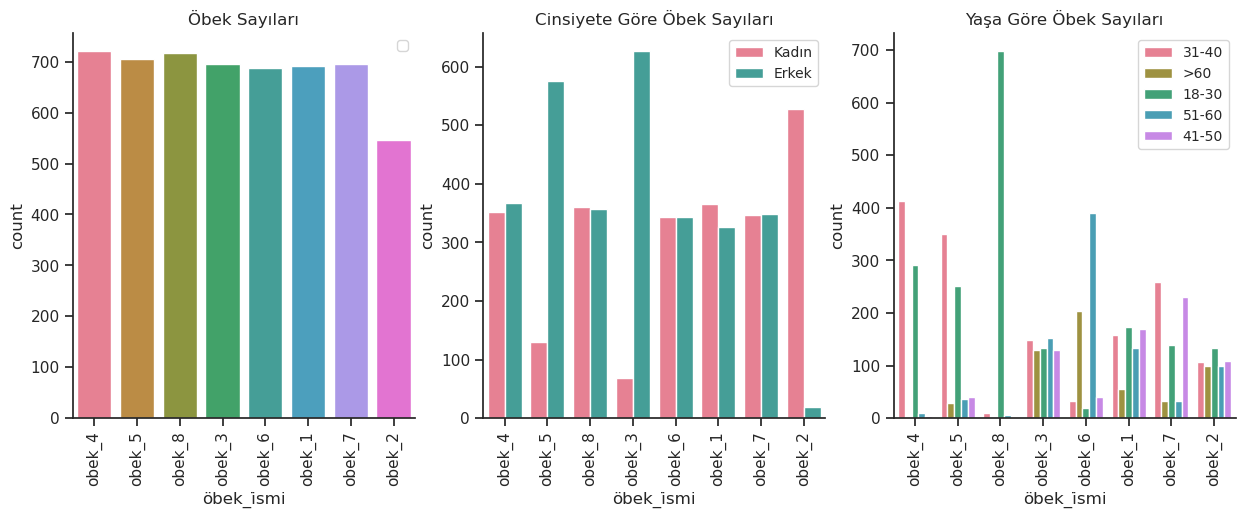

In [15]:
plot_categorical_data(
    'öbek_i̇smi', None,
    'öbek_i̇smi', 'cinsiyet',
    'öbek_i̇smi', 'yaş_grubu',
    "Öbek Sayıları", "Cinsiyete Göre Öbek Sayıları", "Yaşa Göre Öbek Sayıları", 3
)

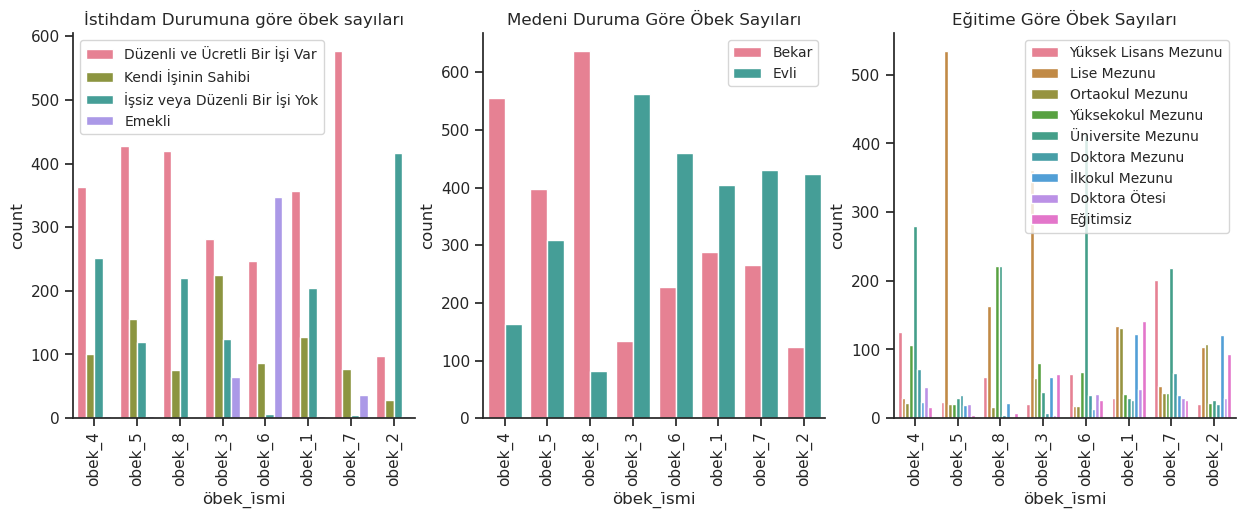

In [16]:
plot_categorical_data(
    'öbek_i̇smi', 'i̇stihdam_durumu',
    'öbek_i̇smi', 'medeni_durum',
    'öbek_i̇smi', 'eğitim_düzeyi',
    "İstihdam Durumuna göre öbek sayıları", "Medeni Duruma Göre Öbek Sayıları", "Eğitime Göre Öbek Sayıları", 3
)

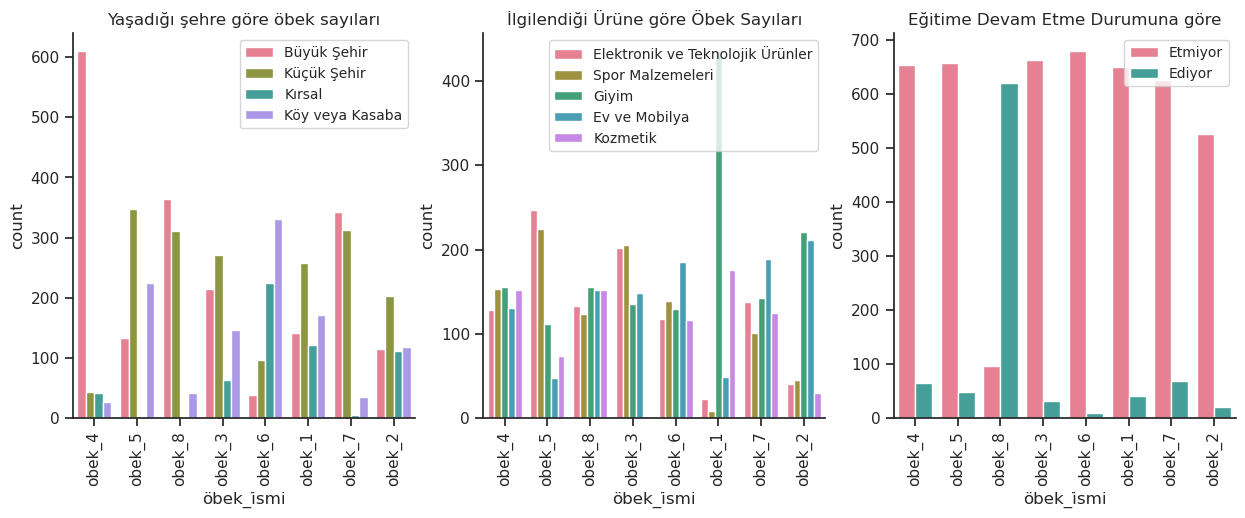

In [17]:
plot_categorical_data(
    'öbek_i̇smi', 'yaşadığı_şehir',
    'öbek_i̇smi', 'en_çok_i̇lgilendiği_ürün_grubu',
    'öbek_i̇smi', 'eğitime_devam_etme_durumu',
    "Yaşadığı şehre göre öbek sayıları", "İlgilendiği Ürüne göre Öbek Sayıları", "Eğitime Devam Etme Durumuna göre", 3
)

Bu kısımda kategorik özelliklerin yer aldığı öbeklere göre dağılımını inceledik;
* **Öbek 2** diğer öbeklerden biraz daha az elemana sahip olsada genel olarak dengeli bir veri setine sahibiz.
* Cinsiyete göre **Öbek 2** çoğunlukla kadınlardan oluşuyor, **Öbek 5** ve **Öbek 3** çoğunlukla erkeklerden oluşurken diğer gruplar ise eşit dağılıma sahip.
* Yaşa göre **Öbek 2** ve **Öbek 3** dengeli dağılıma sahip ancak **60 yaş üstü** grup genel olarak daha az kişiden oluşuyor. Bu tür durumlar aşağıda yeni görselleştirmeler ile gösterilecek. **Öbek 8** neredeyse tamamen **18-30** yaş arası insanlardan oluşuyor. **Öbek 4 ve 5** çoğunlukla **18-40** yaş arasındaki insanlardan oluşuyor.
* İstihdam durumuna göre **Öbek 2** çoğunlukla iş sahibi olmayan insanlardan oluşuyor. **Öbek 7** ise çoğunlukla düzenli çalışan insanlardan oluşuyor.
* Medeni Duruma göre **Öbek 8** ve **Öbek 4**'ü genel olarak **bekar** olarak yorumlayabiliriz. Buna ek olarak **Öbek 2** ve **Öbek 3** ise genellikle evli insanlardan oluşuyor.
* Eğitim düzeyine göre **Öbek 5 ve Öbek 3** genellikle lise mezunu, **Öbek 6 ve Öbek 4** Üniversite Mezunu iken **Öbek 7** genel olarak Üniversite veya Yüksek lisans mezunlarından oluşuyor.
* Yaşadığı yere göre **Öbek 4** büyük şehirlerde yaşayan insanlardan, **Öbek 7 ve 8** şehirde yaşayan, **Öbek 6** ise çoğunlukla şehir dışında yaşayan insanlardan oluşuyor.
* En çok ilgilenilen ürünler **Öbek 1**'in **giyim ve kozmetik** ürünlerine olan ilgisi dışında bize bir genelleme sunmuyor.

Hala bakmadığımız değişkenler olduğu için kesin çıkarımlar yapamayız ama, şuanki bulgulara göre öbekler;
* Öbek 1 genellikle giyim ve kozmetik ürünleri ile ilgilenen, eğitime devam etmeyen insanları içerir.
* Öbek 2 genellikle evli, çalışmayan kadınları içeriyor.
* Öbek 3 genellikle lise mezunu, evli, çalışan erkeklerden oluşuyor. 
* Öbek 4 genellikle yüksek eğitimli, bekar, büyük şehirde yaşayan 18-40 yaş arasında bulunan insanlardan oluşuyor.
* Öbek 5 geneli lise mezunu, çalışan 18-40 yaş arası erkeklerden oluşuyor.
* Öbek 6 genellikle yaşlı, emekli veya emekliliğe yakın yüksek eğitimli insanlardan oluşuyor.
* Öbek 7 genellikle iyi eğitimli, çoğunluğu iş sahibi olan, yetişkin insanlardan oluşuyor.
* Öbek 8 ise çoğunlukla bekar, öğrenci gençleri içeriyor.

## 2. Kategorik özelliklerin kendi içinde dağılımı

In [18]:
def plot_pie(features, titles, binaries, n_cols=3):
    """
    Kategorik veri için pasta grafikleri çizen bir fonksiyon.

    Parametreler:
        features (list): Pasta grafikleri çizilmek istenen özellik adlarını içeren liste.
        titles (list): Grafik başlıkları.
        binaries (list): İkili kategorik özellikler için True, çoklu kategorikler için False içeren liste.
        n_cols (int): Oluşturulan alt grafik sütun sayısı.

    Çıktı:
        Alt grafikler içeren bir görsel çizimi.
    """
    if n_cols == 2:
        fig, (ax1, ax2) = plt.subplots(ncols=n_cols, figsize=(12, 5))
    elif n_cols == 1:
        fig, ax1 = plt.subplots(ncols=n_cols, figsize=(15, 5))
    else:
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=n_cols, figsize=(20, 8))

    for i in range(n_cols):
        colors = ['#37306B', '#D27685'] if binaries[i] else ['#EA698B', '#D55D92', '#C05299',
                                                             '#973AA8', '#822FAF', '#6D23B6',
                                                             '#6411AD', '#571089', '#47126B',
                                                             '#D27685']
        ax = ax1 if i == 0 else (ax2 if i == 1 else ax3)
        ax.pie(df_train[features[i]].value_counts(), labels=df_train[features[i]].unique(),
               autopct="%0.f%%", colors=colors,
               textprops={'color': 'white'})

        ax.set_title(f"{titles[i]} Dağılımı")
        if n_cols == 2:
            ax.legend(prop={'size': 6})
        else:
            ax.legend(prop={'size': 11})

    plt.tight_layout()
    plt.show()

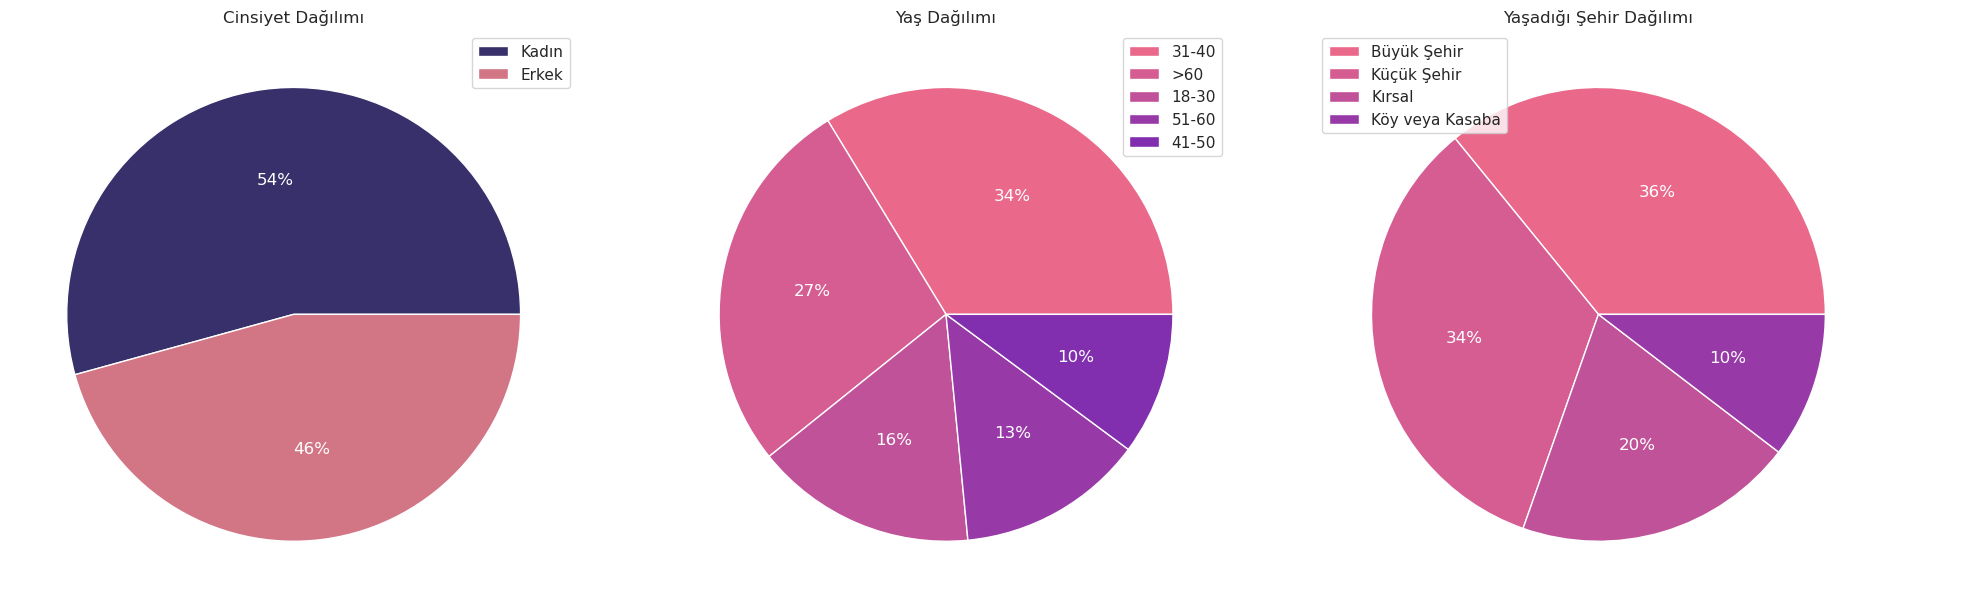

In [19]:
plot_pie(["cinsiyet", "yaş_grubu", "yaşadığı_şehir"],
         ["Cinsiyet", "Yaş", "Yaşadığı Şehir"], 
         [True, False, False], 3)

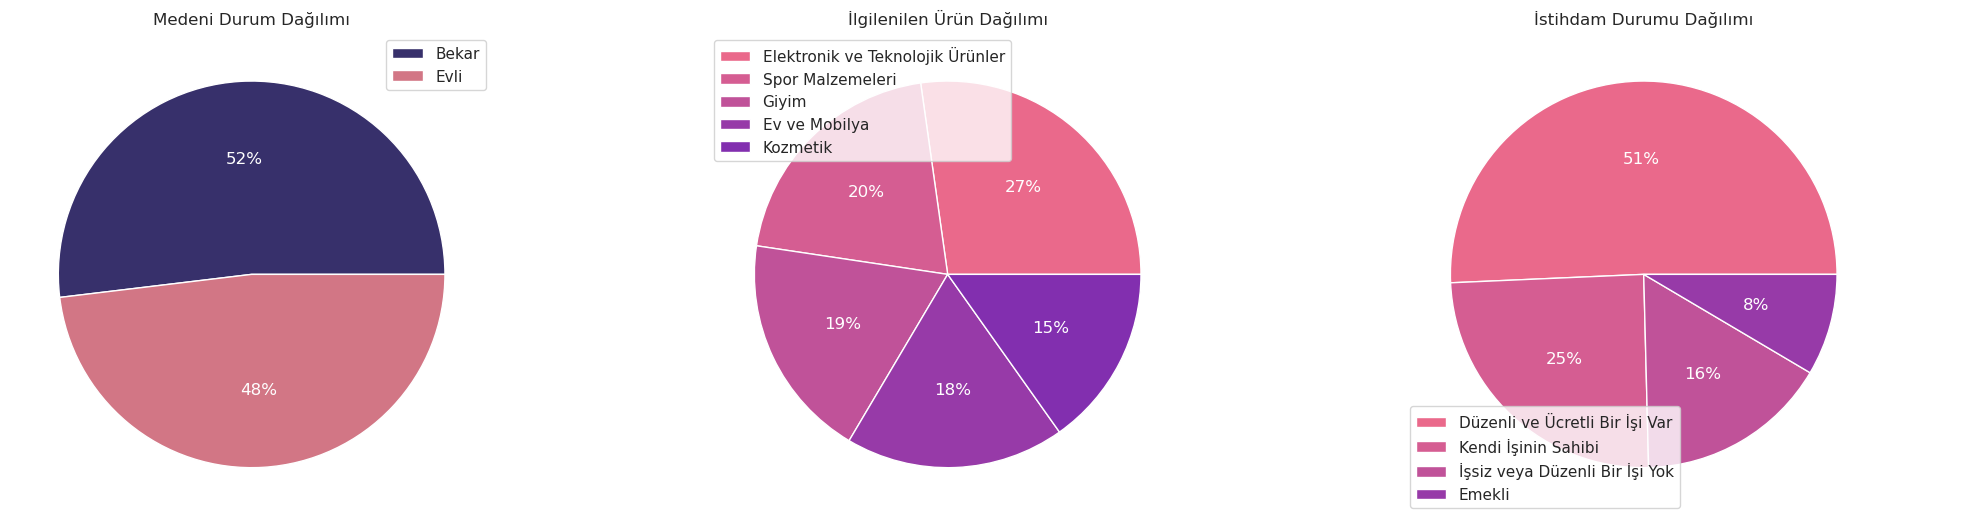

In [20]:
plot_pie(["medeni_durum", "en_çok_i̇lgilendiği_ürün_grubu", "i̇stihdam_durumu"],
         ["Medeni Durum", "İlgilenilen Ürün", "İstihdam Durumu"], 
         [True, False, False], 3)

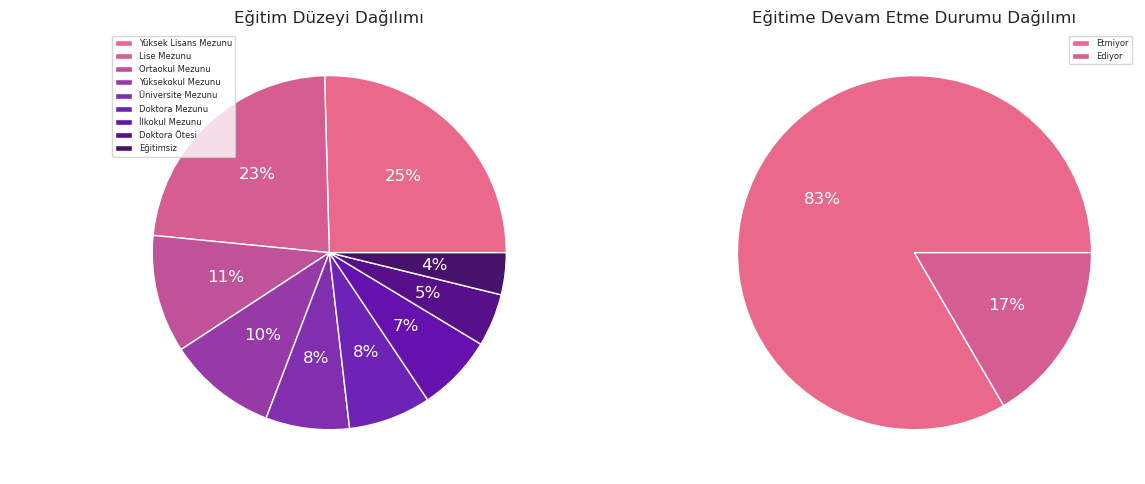

In [21]:
plot_pie(["eğitim_düzeyi", "eğitime_devam_etme_durumu"],
         ["Eğitim Düzeyi", "Eğitime Devam Etme Durumu"], 
         [False, False], 2)

* **Cinsiyet, Medeni Durum ve İlgilenilen Ürün** dengeli dağılmış.
* **Yaş Dağılımı** 41-60 yaş aralığındaki insanlara daha az yer vermiş.
* Çoğunlukla **şehirde yaşayan** insanlar eğitim setinde bulunuyor.
* **Eğitim düzeyine göre** Lise ve Yüksek lisans mezunu insanlara daha çok yer verilmişken veri setindeki eğitimsiz insan sayısı az. Ve büyük çoğunlukla **eğitime devam etmiyor**.
* **İstihdam durumuna** göre çoğunluğu iş sahibi insanlar oluşturuyor ve emekli insanlar azınlığı oluşturuyor.

**Bu çıkarımlara göre genel hedef kitle, 30 yaş üstü, eğitimli ve çalışan insanlardır.**

## 3. Sayısal Özellikler

In [22]:
def plot_distribution(feature, data=df_train):
    """
    Sayısal veri dağılımlarını görselleştiren bir fonksiyon.

    Parametreler:
        feature (str): Görselleştirilmek istenen sayısal özellik adı.
        data (DataFrame): Veri çerçevesi. Varsayılan olarak eğitim veri çerçevesi kullanılır.

    Çıktı:
        Sayısal veri dağılımını gösteren bir histogram, kutu grafiği ve KDE grafiği içeren bir görsel çizimi.
    """
    # İki subplot yan yana olacak şekilde düzenleniyor
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 5))
    
    # Histogram (veri dağılımı) grafiği çizdiriliyor
    sns.histplot(data, x=feature, color='#ff1a66', ax=ax1, kde=True)
    ax1.axvline(x=data[feature].median(), color='black', lw=2)
    ax1.text(x=data[feature].median() + data[feature].median()*0.2, y=590, s='Medyan', color='black')
    
    # Kutu grafiği (boxplot) çizdiriliyor
    sns.boxplot(data=data, x=feature, ax=ax2, whis=2.5)
    
    # KDE grafiği çizdiriliyor
    sns.kdeplot(data=data, x=feature, hue="öbek_i̇smi", shade=True)
    
    # Başlık ve aralık ayarları yapılıyor
    fig.suptitle(f"{feature.capitalize().replace('_', ' ')} Dağılımı", fontsize=14, fontweight='normal')
    plt.subplots_adjust(wspace=0.3)  # Alt grafikler arası boşluk ayarı
    
    plt.show()

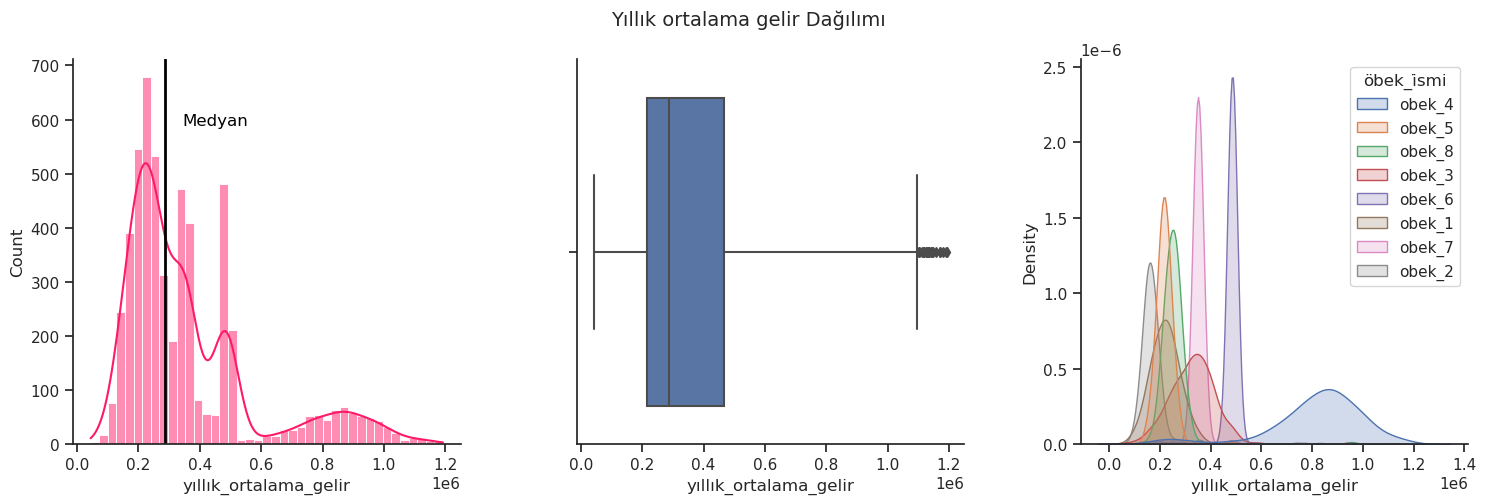

In [23]:
plot_distribution("yıllık_ortalama_gelir")

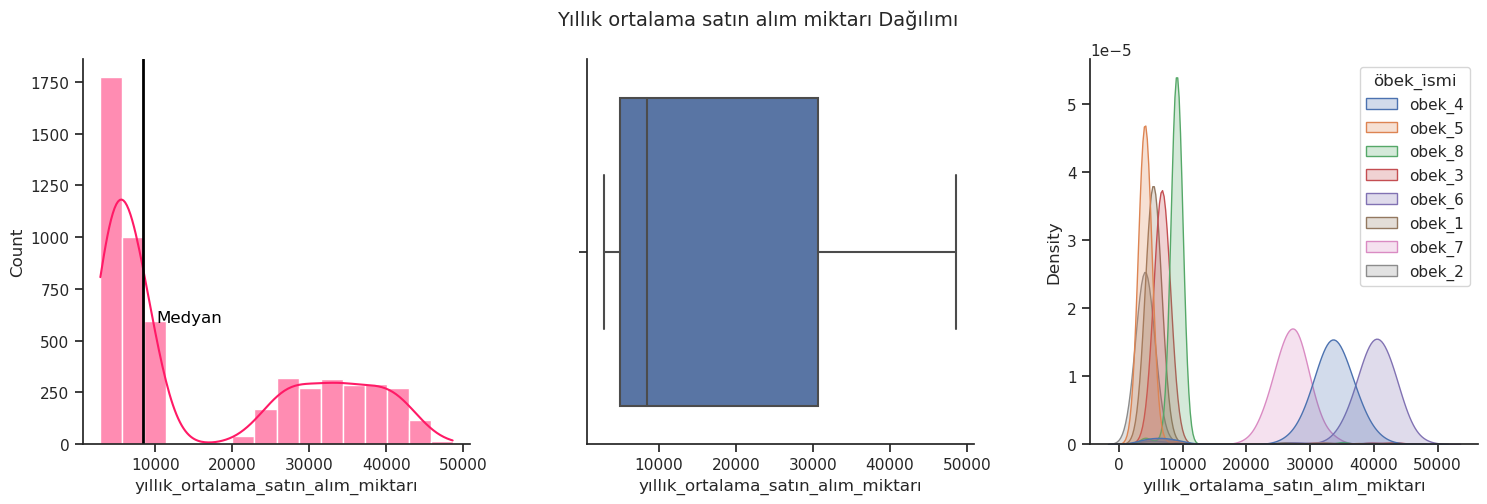

In [24]:
plot_distribution("yıllık_ortalama_satın_alım_miktarı")

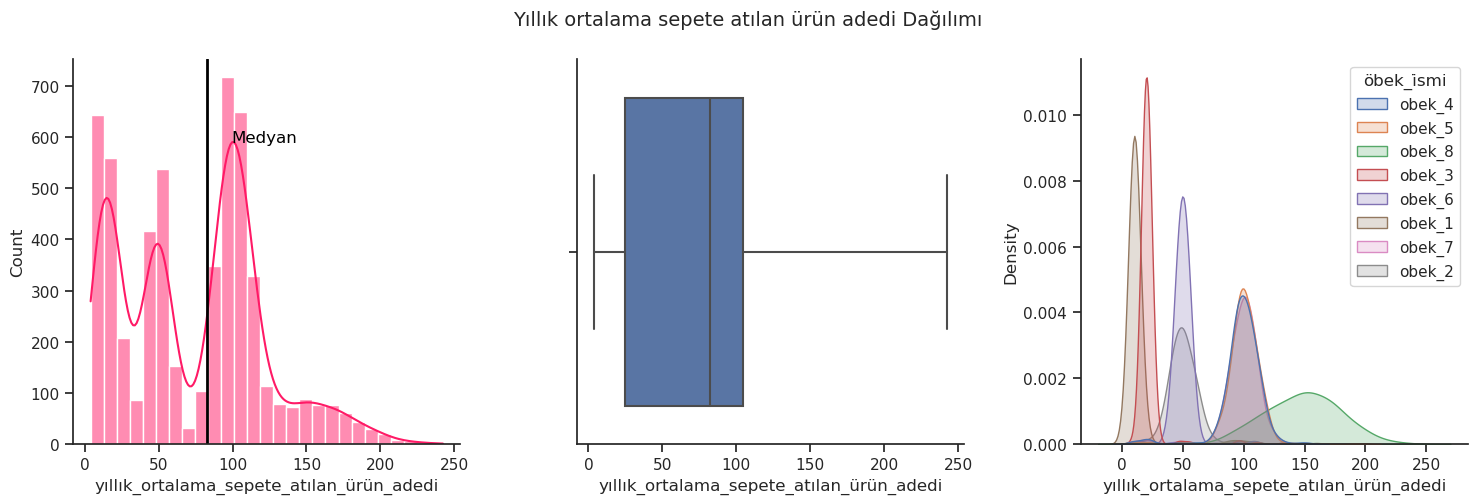

In [25]:
plot_distribution("yıllık_ortalama_sepete_atılan_ürün_adedi")

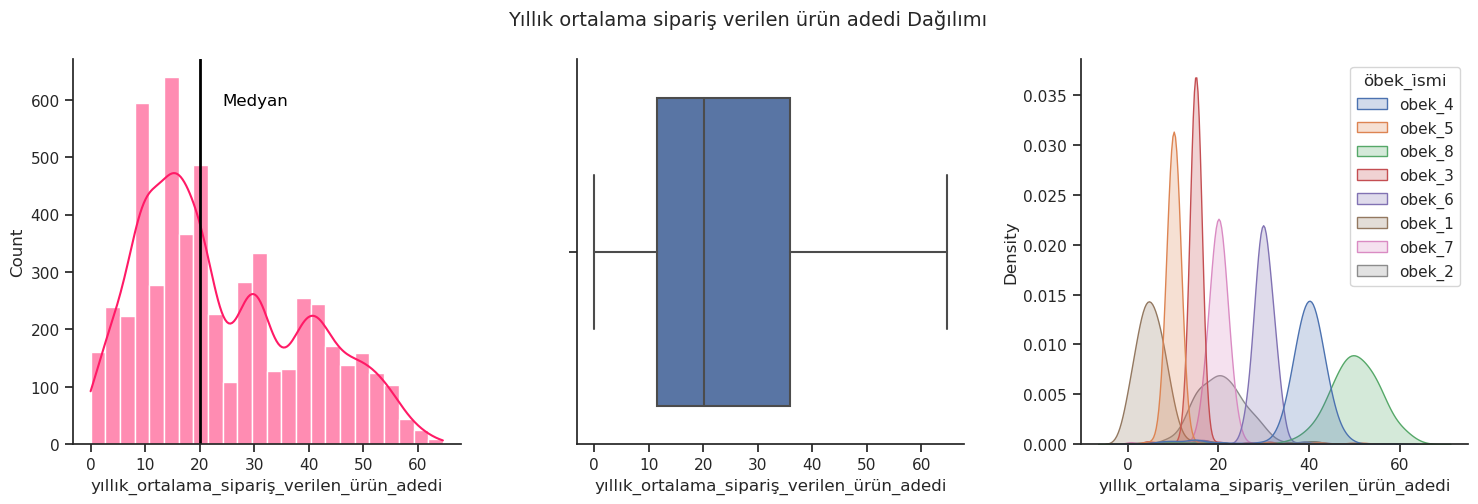

In [26]:
plot_distribution("yıllık_ortalama_sipariş_verilen_ürün_adedi")

Sayısal verilerin bulunduğu segmentin farklı olduğunu daha önce söylemiştim bunun için **normalizasyon** uygulayacağız, verilerin çarpık olduğu dağılımlara ise **log transformation** uygulayacağız.

**Sayısal verilere göre öbekler için yaptığımız yorumları güncelleyeceğiz;**
* Öbek 1 genellikle giyim ve kozmetik ürünleri ile ilgilenen, eğitime devam etmeyen, **düşük gelirli** insanları içerir. (**düşük satın alım**)
* Öbek 2 genellikle evli, çalışmayan **ortalama ve düşük gelirli** kadınları içeriyor. (**Az ürün sipariş ediyorlar**)
* Öbek 3 genellikle lise mezunu, evli, çalışan, geliri **ortalama çevresinde dağılan** erkeklerden oluşuyor. (**düşük satın alım**)
* Öbek 4 genellikle yüksek eğitimli, bekar, büyük şehirde yaşayan 18-40 yaş arasında bulunan **yüksek gelirli** insanlardan oluşuyor.
* Öbek 5 geneli lise mezunu, çalışan 18-40 yaş arası **orta gelirli** erkeklerden oluşuyor. (**az satın alım yapıyorlar**)
* Öbek 6 genellikle yaşlı, emekli veya emekliliğe yakın yüksek eğitimli **çoğunluğu ortalama üstü gelirli** insanlardan oluşuyor.
* Öbek 7 genellikle iyi eğitimli, çoğunluğu iş sahibi olan **ortalama ve üstü gelirli**, yetişkin insanlardan oluşuyor. (**ortalama ve üstü miktarlarda ürün alım, sepete ekleme**)
* Öbek 8 ise çoğunlukla **ortalama ve altı gelirli** bekar, öğrenci gençleri içeriyor. (**Sepete çok ürün ekliyorlar ve çok fazla ürün sipariş veriyorlar**)

**Ortalama gelirin diğer sayısal verilere etki ettiği kolayca görülebilir**

# 6. Feature Engineering (Özellik Mühendisliği)

## 1. Yeni Özellik: alım_oranı


In [27]:
# Eğitim veri setinde "alım_oranı" özelliğini hesaplama ve ekme
df_train["alım_oranı"] = df_train["yıllık_ortalama_sipariş_verilen_ürün_adedi"] / df_train["yıllık_ortalama_sepete_atılan_ürün_adedi"]

# Test veri setinde "alım_oranı" özelliğini hesaplama ve ekme
df_test["alım_oranı"] = df_test["yıllık_ortalama_sipariş_verilen_ürün_adedi"] / df_test["yıllık_ortalama_sepete_atılan_ürün_adedi"]

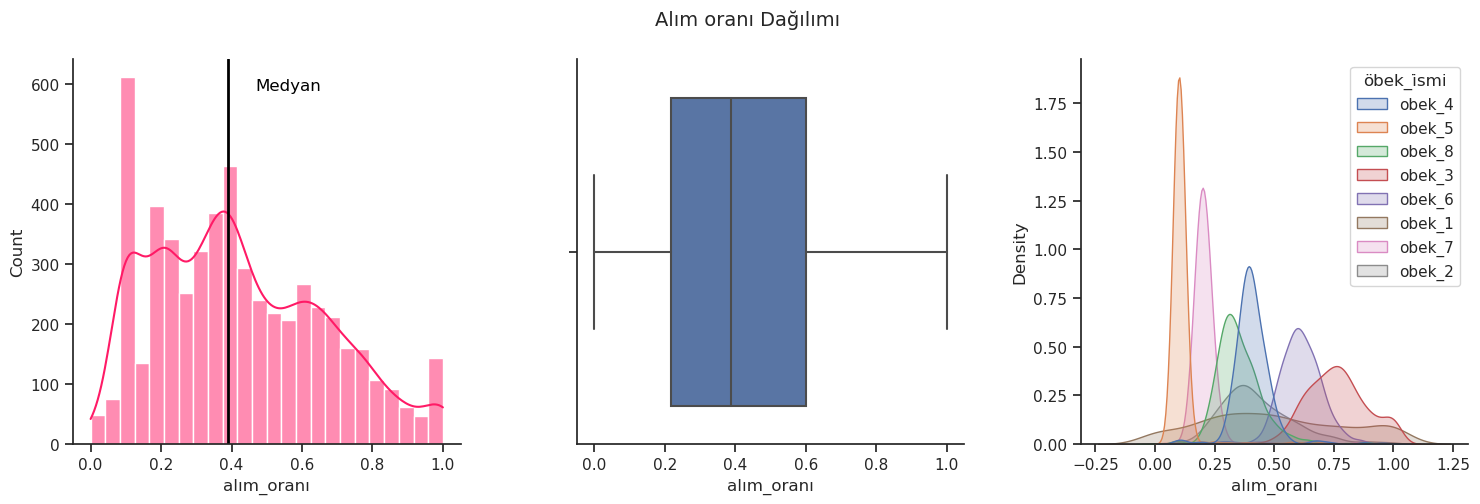

In [28]:
plot_distribution("alım_oranı")

## 2. Yeni Özellik: gelir_grubu
Müşterileri gelirlerine göre 4 gruptan birine dağıtıyoruz.

In [29]:
# Gelir gruplarını tanımlama için kesme noktalarını belirleme
gelir_kesme_noktalari = [40000, 200000, 300000, 500000, 1500000]

# Gelir grupları etiketlerini oluşturma
gelir_grup_etiketleri = ["Düşük Gelir", "Orta Gelir", "Orta Üstü Gelir", "Yüksek Gelir"]

# "Yıllık Ortalama Gelir" sütununa göre gelir gruplarını oluşturma
df_train["gelir_grubu"] = pd.cut(df_train["yıllık_ortalama_gelir"], bins=gelir_kesme_noktalari, labels=gelir_grup_etiketleri)
df_test["gelir_grubu"] = pd.cut(df_test["yıllık_ortalama_gelir"], bins=gelir_kesme_noktalari, labels=gelir_grup_etiketleri)

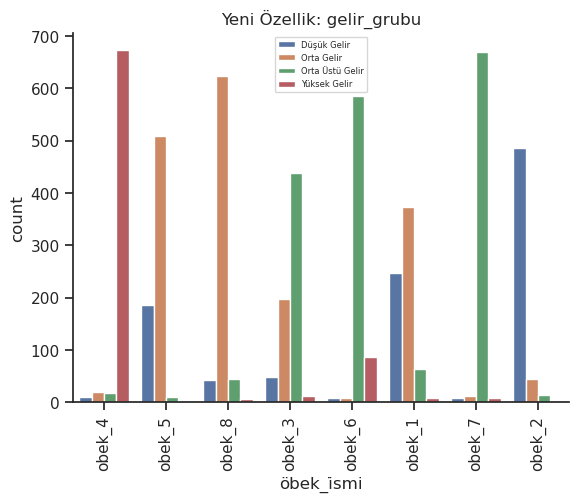

In [30]:
# Yeni bir alt grafik oluşturma
ax = sns.countplot(data=df_train, x='öbek_i̇smi', hue="gelir_grubu")

# X ekseni etiketlerini döndürme
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Görseldeki legendları ayarlama
ax.legend(prop={'size': 6})

# Görsel başlığı ayarlama
ax.set_title("Yeni Özellik: gelir_grubu")

# Görseli göster
plt.show()

## 3. Yeni Özellik: ortalama_ödeme

Ürün başına ödediği ortalam ücreti gösteren yeni özellik.

In [31]:
# Eğitim veri setinde "ortalama_ödeme" özelliğini hesaplama ve ekme
df_train["ortalama_ödeme"] = df_train["yıllık_ortalama_satın_alım_miktarı"] / df_train["yıllık_ortalama_sepete_atılan_ürün_adedi"]

# Test veri setinde "ortalama_ödeme" özelliğini hesaplama ve ekme
df_test["ortalama_ödeme"] = df_test["yıllık_ortalama_satın_alım_miktarı"] / df_test["yıllık_ortalama_sepete_atılan_ürün_adedi"]

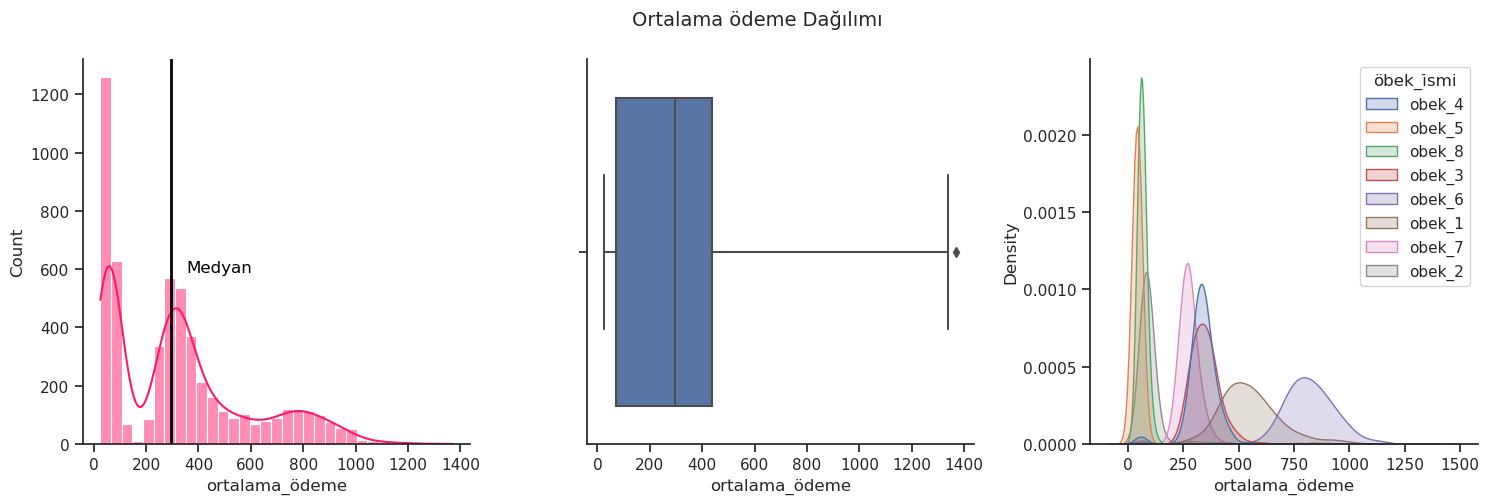

In [32]:
plot_distribution("ortalama_ödeme")

## 4. Yeni Özellik: satın_alma_etkinliği

Yıllık gelirinin ne kadarını bu alışverişlerde harcadığını gösteren oransal yeni veri.

In [33]:
# Eğitim veri setinde "satın_alma_etkinliği" özelliğini hesaplama ve ekme
df_train["satın_alma_etkinliği"] = df_train["yıllık_ortalama_satın_alım_miktarı"] / df_train["yıllık_ortalama_gelir"]

# Test veri setinde "satın_alma_etkinliği" özelliğini hesaplama ve ekme
df_test["satın_alma_etkinliği"] = df_test["yıllık_ortalama_satın_alım_miktarı"] / df_test["yıllık_ortalama_gelir"]

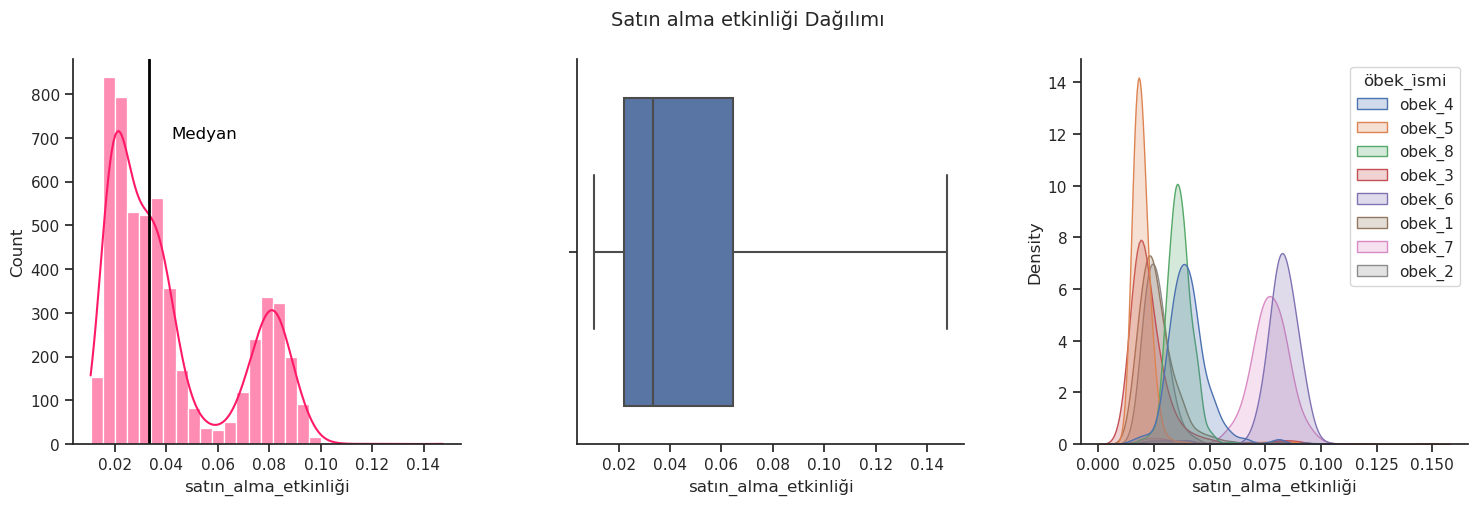

In [34]:
# İki subplot yan yana olacak şekilde düzenleniyor
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 5))

# Histogram (veri dağılımı) grafiği çizdiriliyor
sns.histplot(data=df_train, x="satın_alma_etkinliği", color='#ff1a66', ax=ax1, kde=True)
ax1.axvline(x=df_train["satın_alma_etkinliği"].median(), color='black', lw=2)
ax1.text(x=df_train["satın_alma_etkinliği"].mean(), y=700, s='Medyan', color='black')

# Kutu grafiği (boxplot) çizdiriliyor
sns.boxplot(data=df_train, x="satın_alma_etkinliği", ax=ax2, whis=2.5)

# KDE grafiği çizdiriliyor
sns.kdeplot(data=df_train, x="satın_alma_etkinliği", hue="öbek_i̇smi", shade=True)

# Başlık ve aralık ayarları yapılıyor
fig.suptitle(f"{'Satın Alma Etkinliği'.capitalize().replace('_', ' ')} Dağılımı", fontsize=14, fontweight='normal')
plt.subplots_adjust(wspace=0.3)  # Alt grafikler arası boşluk ayarı

plt.show()

Bir sonraki eklenecekler özellikler veri ön işleme gerektiriyor. Bu yüzden feature engineering daha sonra devam edecektir.

# 7. Veri Ön İşleme (Data Preprocessing)

## 1. Log Transform

In [35]:
def log_transform(col_list):
    """
    Belirli özellikler için log dönüşümü gerçekleştiren bir fonksiyon.

    Parametreler:
        col_list (list): Log dönüşümü uygulanacak özelliklerin listesi.

    Çıktı:
        Veri çerçevesinde belirtilen özellikler için log dönüşümü gerçekleştirilir.
    """
    for col in col_list:
        # Eğer özelliğin çarpıklığı 0.5'ten büyükse
        if abs(skew(df_train[col])) > 0.5:
            # Log dönüşümü uygulanır
            df_train[col] = np.log(df_train[col] + 1)
            df_test[col] = np.log(df_test[col] + 1)

# Belirtilen sayısal özellikler için log dönüşümü uygulanır
log_transform(config.NUMERIC_COLUMNS)

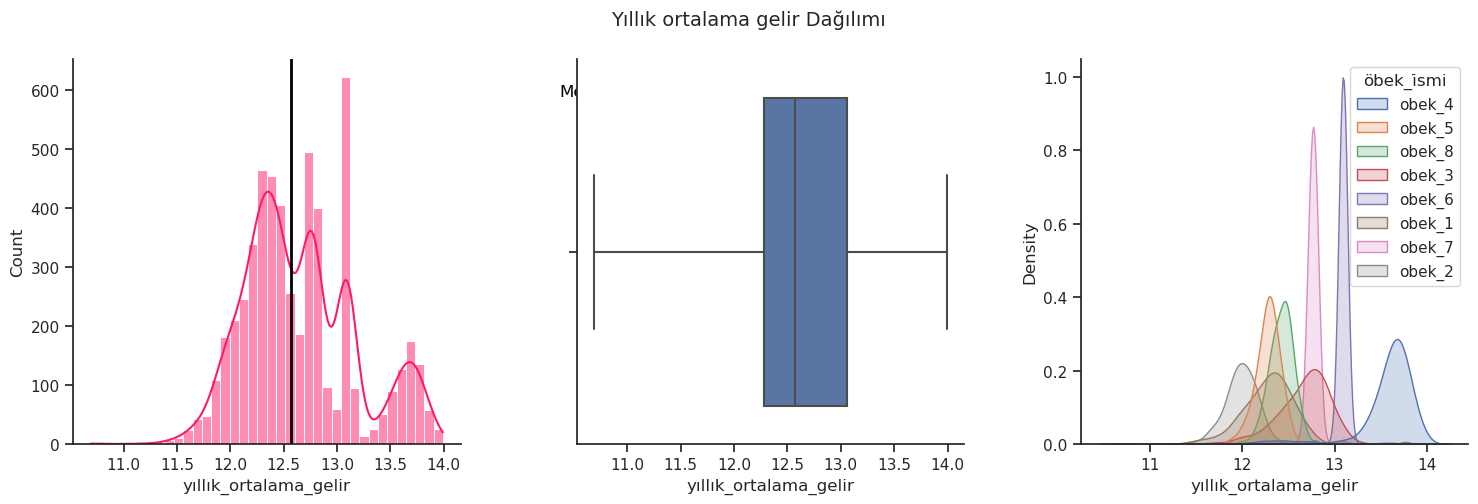

In [36]:
plot_distribution("yıllık_ortalama_gelir")

Burada görüldüğü gibi **asimetriklik** problemi ortadan kalkmıştır.

In [37]:
# Eğitim veri setinin indeks sütununu kaydetme
train_index = df_train["index"]

# Test veri setinin indeks sütununu kaydetme
test_index = df_test["index"]

# Eğitim veri setinden indeks sütununu kaldırma
df_train.drop("index", axis=1, inplace=True)

# Test veri setinden indeks sütununu kaldırma
df_test.drop("index", axis=1, inplace=True)

In [38]:
# Eğitim veri setinin "öbek_i̇smi" sütunundaki hedef değerleri ayırma
y_train = df_train["öbek_i̇smi"]

# Eğitim veri setinden "öbek_i̇smi" sütununu kaldırma
df_train.drop("öbek_i̇smi", axis=1, inplace=True)

In [39]:
def get_y(y):
    """
    Öbek isimlerini sayısal etiketlere dönüştüren bir fonksiyon.

    Parametreler:
        y (str): Dönüştürülecek öbek ismi.

    Çıktı:
        Verilen öbek ismine karşılık gelen sayısal etiketi döndürür.
    """
    if y == "obek_1":
        return 0
    elif y == "obek_2":
        return 1
    elif y == "obek_3":
        return 2    
    elif y == "obek_4":
        return 3
    elif y == "obek_5":
        return 4
    elif y == "obek_6":
        return 5
    elif y == "obek_7":
        return 6
    elif y == "obek_8":
        return 7

# Hedef değerleri sayısal etiketlere dönüştürme
y = y_train.apply(get_y)

In [40]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5460 entries, 0 to 5459
Data columns (total 16 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   cinsiyet                                    5460 non-null   object  
 1   yaş_grubu                                   5460 non-null   object  
 2   medeni_durum                                5460 non-null   object  
 3   eğitim_düzeyi                               5460 non-null   object  
 4   i̇stihdam_durumu                            5460 non-null   object  
 5   yıllık_ortalama_gelir                       5460 non-null   float64 
 6   yaşadığı_şehir                              5460 non-null   object  
 7   en_çok_i̇lgilendiği_ürün_grubu              5460 non-null   object  
 8   yıllık_ortalama_satın_alım_miktarı          5460 non-null   float64 
 9   yıllık_ortalama_sipariş_verilen_ürün_adedi  5460 non-null   float64 
 10  

## 2. Encoding ve Standartlaştırma

In [41]:
# Kodlanacak sütunlar
selected_columns_oe = ["eğitim_düzeyi", "yaş_grubu", "gelir_grubu"]

# Seviye etiketleri
oe_levels = {
    "education_levels": ['Eğitimsiz', 'İlkokul Mezunu', 'Ortaokul Mezunu',
                         'Lise Mezunu', 'Yüksekokul Mezunu', 'Üniversite Mezunu',
                         'Yüksek Lisans Mezunu', 'Doktora Mezunu', 'Doktora Ötesi'],
    "age_levels": ['18-30', '31-40', '41-50', '51-60', '>60'],
    "income_levels": ['Düşük Gelir', 'Orta Gelir', 'Orta Üstü Gelir', 'Yüksek Gelir']
}

# OrdinalEncoder'ları oluşturma
ordinal_encoder_edu = OrdinalEncoder(categories=[oe_levels["education_levels"]])
ordinal_encoder_age = OrdinalEncoder(categories=[oe_levels["age_levels"]])
ordinal_encoder_income = OrdinalEncoder(categories=[oe_levels["income_levels"]])

# Seçilen sütunları kodlama
df_train["eğitim_düzeyi"] = ordinal_encoder_edu.fit_transform(df_train[["eğitim_düzeyi"]])
df_train["yaş_grubu"] = ordinal_encoder_age.fit_transform(df_train[["yaş_grubu"]])
df_train["gelir_grubu"] = ordinal_encoder_income.fit_transform(df_train[["gelir_grubu"]])

# Test veri seti için de aynı kodlamayı uygulama
df_test["eğitim_düzeyi"] = ordinal_encoder_edu.transform(df_test[["eğitim_düzeyi"]])
df_test["yaş_grubu"] = ordinal_encoder_age.transform(df_test[["yaş_grubu"]])
df_test["gelir_grubu"] = ordinal_encoder_income.transform(df_test[["gelir_grubu"]])

In [42]:
# Sayısal sütunlar
numeric_columns = ["yıllık_ortalama_gelir", "satın_alma_etkinliği", "ortalama_ödeme", "alım_oranı",
                   "yıllık_ortalama_satın_alım_miktarı", "yıllık_ortalama_sipariş_verilen_ürün_adedi",
                   "yıllık_ortalama_sepete_atılan_ürün_adedi"]

# Kategorik sütunlar
categorical_columns = ["cinsiyet", "medeni_durum", "eğitime_devam_etme_durumu",
                       "en_çok_i̇lgilendiği_ürün_grubu", "yaşadığı_şehir", "i̇stihdam_durumu"]

# Standart Scaling işlem adımları
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# One-Hot Encoding işlem adımları
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False, drop='if_binary'))
])

# Sütun dönüşümlerini birleştirme
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ],
    remainder='passthrough',  # Diğer sütunları geçiştir
    verbose_feature_names_out=False
)

# Verileri dönüştürme
train_transformed = preprocessor.fit_transform(df_train)
test_transformed = preprocessor.transform(df_test)

# Dönüştürülmüş verileri DataFrame'e dönüştürme
df_train = pd.DataFrame(train_transformed, columns=preprocessor.get_feature_names_out())
df_test = pd.DataFrame(test_transformed, columns=preprocessor.get_feature_names_out())

In [43]:
# Yeniden düzenlenmiş sütun adları
col_names = {
    'old_names': df_train.columns.tolist(),
    'new_names': [col.lower().replace(' ', "_") for col in df_train.columns.tolist()],
    'new_names_test': [col.lower().replace(' ', "_") for col in df_test.columns.tolist()]
}

# Eğitim veri çerçevesinin sütun adlarını güncelleme
df_train.columns = col_names['new_names']

# Test veri çerçevesinin sütun adlarını güncelleme
df_test.columns = col_names['new_names_test']

In [44]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5460 entries, 0 to 5459
Data columns (total 26 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   yıllık_ortalama_gelir                                            5460 non-null   float64
 1   satın_alma_etkinliği                                             5460 non-null   float64
 2   ortalama_ödeme                                                   5460 non-null   float64
 3   alım_oranı                                                       5460 non-null   float64
 4   yıllık_ortalama_satın_alım_miktarı                               5460 non-null   float64
 5   yıllık_ortalama_sipariş_verilen_ürün_adedi                       5460 non-null   float64
 6   yıllık_ortalama_sepete_atılan_ürün_adedi                         5460 non-null   float64
 7   cinsiyet_kadın                            

## 3. Yeni Özellik: müşteri_kimliği (PCA)

In [45]:
# Gerekli kütüphaneleri içe aktarın
from sklearn.decomposition import PCA

# Müşteri davranışı için seçilen önemli özelliklerin listesi
selected_columns_mk = ['gelir_grubu', 'eğitim_düzeyi', 'yaş_grubu',
                       'i̇stihdam_durumu_düzenli_ve_ücretli_bir_i̇şi_var', 'i̇stihdam_durumu_emekli',
                       'i̇stihdam_durumu_kendi_i̇şinin_sahibi',
                       'i̇stihdam_durumu_i̇şsiz_veya_düzenli_bir_i̇şi_yok', 'yaşadığı_şehir_kırsal',
                       'yaşadığı_şehir_küçük_şehir', 'yaşadığı_şehir_köy_veya_kasaba',
                       'yaşadığı_şehir_büyük_şehir', 'eğitime_devam_etme_durumu_etmiyor',
                       'medeni_durum_evli', 'cinsiyet_kadın']

# PCA nesnesi oluşturun
pca = PCA(n_components=1)

# Eğitim verisi üzerinde PCA dönüşümü gerçekleştirin
mk = pca.fit_transform(df_train[selected_columns_mk])

# Test verisi üzerinde PCA dönüşümü gerçekleştirin
mk_t = pca.transform(df_test[selected_columns_mk])

In [46]:
# Eğitim verisi üzerine PCA sonuçlarını "müşteri_kimliği" sütunu olarak ekleyin
df_train["müşteri_kimliği"] = mk

# Test verisi üzerine PCA sonuçlarını "müşteri_kimliği" sütunu olarak ekleyin
df_test["müşteri_kimliği"] = mk_t

## 4. Yeni Özellik: müşteri_kümeleri (Soft Clustering)

In [47]:
# K-Means modelini oluştur
kmeans = KMeans(n_clusters=8, n_init=50, random_state=config.SEED)
kmeans.fit(df_train)

# Her veri noktasının her bir kümeye olan uzaklığını hesapla
distances = kmeans.transform(df_train)

# Soft clustering (yumuşak kümeleme) hesapla
soft_clusters = np.exp(-distances ** 2 / (2.0 * (np.std(distances) ** 2)))
soft_clusters /= np.sum(soft_clusters, axis=1, keepdims=True)

# Her bir veri noktasının en yüksek olasılığa sahip küme indeksini bul
labels = np.argmax(soft_clusters, axis=1)

# Test seti için işlemleri tekrarla
distances_t = kmeans.transform(df_test)

soft_clusters_t = np.exp(-distances_t ** 2 / (2.0 * (np.std(distances_t) ** 2)))
soft_clusters_t /= np.sum(soft_clusters_t, axis=1, keepdims=True)

# Her bir veri noktasının en yüksek olasılığa sahip küme indeksini bul
labels_t = np.argmax(soft_clusters_t, axis=1)

In [48]:
# PCA modelini oluştur
pca = PCA(n_components=2, random_state=config.SEED)

# Eğitim verisi üzerinde soft_clusters'ı kullanarak PCA dönüşümü gerçekleştir
müşteri_kümeleri = pca.fit_transform(pd.DataFrame(soft_clusters)).round(3)

# Test verisi üzerinde soft_clusters'ı kullanarak PCA dönüşümü gerçekleştir
müşteri_kümeleri_t = pca.transform(pd.DataFrame(soft_clusters_t)).round(3)

In [49]:
# Eğitim verisine PCA sonuçlarını "müşteri_kümesi_1" ve "müşteri_kümesi_2" sütunları olarak ekle
df_train[["müşteri_kümesi_1", "müşteri_kümesi_2"]] = müşteri_kümeleri

# Test verisine PCA sonuçlarını "müşteri_kümesi_1" ve "müşteri_kümesi_2" sütunları olarak ekle
df_test[["müşteri_kümesi_1", "müşteri_kümesi_2"]] = müşteri_kümeleri_t

In [50]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5460 entries, 0 to 5459
Data columns (total 29 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   yıllık_ortalama_gelir                                            5460 non-null   float64
 1   satın_alma_etkinliği                                             5460 non-null   float64
 2   ortalama_ödeme                                                   5460 non-null   float64
 3   alım_oranı                                                       5460 non-null   float64
 4   yıllık_ortalama_satın_alım_miktarı                               5460 non-null   float64
 5   yıllık_ortalama_sipariş_verilen_ürün_adedi                       5460 non-null   float64
 6   yıllık_ortalama_sepete_atılan_ürün_adedi                         5460 non-null   float64
 7   cinsiyet_kadın                            

# 8. Özellik Seçimi (Feature Importance and Selecting)

In [51]:
# CatBoostClassifier modeli oluşturma
clf = catboost.CatBoostClassifier(n_estimators=200, random_state=config.SEED)
clf.fit(df_train, y, verbose=False)

# Özellik önemlerini alma
feature_importances = clf.feature_importances_

# Özellik önemlerini sıralama ve yazdırma
sorted_indices = np.argsort(feature_importances)[::-1]
for i in sorted_indices:
    print(f"Feature {i+1}: {df_train.columns[i]} - Importance: {feature_importances[i]}")

Feature 3: ortalama_ödeme - Importance: 15.494959610776672
Feature 5: yıllık_ortalama_satın_alım_miktarı - Importance: 14.279065463092273
Feature 1: yıllık_ortalama_gelir - Importance: 13.916615528115955
Feature 6: yıllık_ortalama_sipariş_verilen_ürün_adedi - Importance: 13.85337352398931
Feature 24: yaş_grubu - Importance: 8.705800981012752
Feature 7: yıllık_ortalama_sepete_atılan_ürün_adedi - Importance: 4.778951582049732
Feature 4: alım_oranı - Importance: 4.2864581053527395
Feature 28: müşteri_kümesi_1 - Importance: 3.141519791007317
Feature 29: müşteri_kümesi_2 - Importance: 3.0672444455349694
Feature 2: satın_alma_etkinliği - Importance: 2.6024507379403077
Feature 27: müşteri_kimliği - Importance: 2.3165157294253715
Feature 13: en_çok_i̇lgilendiği_ürün_grubu_giyim - Importance: 1.2777541066929505
Feature 23: i̇stihdam_durumu_i̇şsiz_veya_düzenli_bir_i̇şi_yok - Importance: 1.2365353202456315
Feature 8: cinsiyet_kadın - Importance: 1.2147557652369456
Feature 20: i̇stihdam_durumu_düz

In [52]:
# Özellik önemleri eşiği altındaki sütunların indekslerini alın
indices_to_drop = np.where(feature_importances < 0.5)[0]

# Seçilen özellikleri çıkartma
X_train_selected = df_train.drop(df_train.columns[indices_to_drop], axis=1)
X_test_selected = df_test.drop(df_test.columns[indices_to_drop], axis=1)

In [53]:
# Özellikler arasındaki korelasyon matrisini hesaplama
correlation_matrix = X_test_selected.corr()

# 0.75'ten büyük korelasyona sahip değerleri seçme
correlation_matrix[correlation_matrix > 0.75]

,yıllık_ortalama_gelir,satın_alma_etkinliği,ortalama_ödeme,alım_oranı,yıllık_ortalama_satın_alım_miktarı,yıllık_ortalama_sipariş_verilen_ürün_adedi,yıllık_ortalama_sepete_atılan_ürün_adedi,cinsiyet_kadın,medeni_durum_evli,eğitime_devam_etme_durumu_etmiyor,...,yaşadığı_şehir_büyük_şehir,yaşadığı_şehir_küçük_şehir,i̇stihdam_durumu_düzenli_ve_ücretli_bir_i̇şi_var,i̇stihdam_durumu_kendi_i̇şinin_sahibi,i̇stihdam_durumu_i̇şsiz_veya_düzenli_bir_i̇şi_yok,yaş_grubu,gelir_grubu,müşteri_kimliği,müşteri_kümesi_1,müşteri_kümesi_2
yıllık_ortalama_gelir,1.000000,NaN,NaN,NaN,0.821309,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.939515,NaN,NaN,NaN
satın_alma_etkinliği,NaN,1.000000,NaN,NaN,0.831726,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ortalama_ödeme,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alım_oranı,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yıllık_ortalama_satın_alım_miktarı,0.821309,0.831726,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.813297,NaN,0.861702,NaN
yıllık_ortalama_sipariş_verilen_ürün_adedi,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yıllık_ortalama_sepete_atılan_ürün_adedi,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.771889
cinsiyet_kadın,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
medeni_durum_evli,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
eğitime_devam_etme_durumu_etmiyor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
#Korelasyonu yüksek özelliklerden düşük importance'a sahipleri çıkarma
X_train_selected = df_train.drop('müşteri_kümesi_1', axis=1)
X_test_selected = df_test.drop('müşteri_kümesi_1', axis=1)

# 9. Modelleri Oluşturma ve Geliştirme

MultiClass sınıflandırma modelleri ile başladığım bu yolculukta, herhangi bir feature engineering, data augmentation ve model fine tuning skora hiç katkı sağlamayınca, yeni bir yoldan ilerlemeye karar verdim. Yani her veriyi bireysel bir şekilde değerlendirmek. Bunun sonucunda Kingdom adını verdiğim mimari ve modeli ortaya çıkardım. Görüntü itibari ile karışık olsada hesaplama olarak göründüğü gibi değil, detaylar biraz sonra... Öncelikle model toplam 48 binary classifier'dan oluşuyor. Bunların 40'ı makine öğrenmesi algoritmaları olan, RandomForest, CatBoost, XGBoost, LightGBM, HistGradientBoosting modelleridir. Her bir öbek için her bir algoritma bir kez eğitilmiştir. Ve bunlar Kingdom modelinin Queen parçalarını oluşturuyor. Bunlara ek olarak görselde de mimarilerine yer verdiğim birbirinden farklı 8 derin öğrenme modeli olan king modelleri bulunuyor. Bu 8 king modeli doğrudan sınıflandırma yapmak yerine verinin belirtilen sınıfta olup olmama ihtimalini 0-1 aralığında veriyor. Ancak hesaplama maaliyetin düşmesi için her zaman çalıştırılmıyor. Modelimiz öncelikle gelen veriyi paralel olarak tüm Queen modellerinden geçiriyor. Bu makine öğrenmesi algoritmalarının toplam kaç tanesinin 1 olarak sınıflandırdığına bakıyor. Elde edilen sonuç dizisinde eğer birden fazla 0 olmayan öbek varsa king modelleri devreye giriyor ve 0'dan farklı tüm öbekler için verinin o öbeğe ait olup olmama ihtimalini çıkarıyor. Queen'deki 1 olarak sınıflandırma sayıları ve bu sınıflara ait king olasılıkları çarpılıyor. En yüksek çıktıya sahip olan öbek sonuç olarak üretiliyor. Bu detaylarla birlikte modelin seri bir şekilde değil paralel şekilde inceleme yaptığını gördük. Yani büyük sayı sadece büyük hedef sınıftan kaynaklı. Elimizde az veri olduğu için ve hedef sınıf sayısı yüzler ve binler gibi sayılarla ifade edilmediği için bizim problemimize yönelik oldukça makul ve iyi sonuç üreten bir modeldir.

Queenlerde yer alan modellerin eğitimi aşağıda verilmiştir. Örneğin birinci sınıfa ait modeller, birinci sınıftaki tüm veriler ve aynı sayıdaki rastgele diğer sınıftaki 0 olarak etiketli verilerle eğitilir.

![Mimari](https://i.ibb.co/ZNXFzGc/mimari.png)

## 1. Doğrulama ve eğitim setini ayırma

In [55]:
# Farklı sınıflara ait verileri saklamak için bir sözlük oluşturma
class_data = {}
for class_label in range(8):
    class_data[class_label] = X_train_selected[y == class_label]

# Karşılık gelen etiketleri saklamak için bir sözlük oluşturma
class_labels = {}
for class_label in range(8):
    class_labels[class_label] = len(class_data[class_label]) * [class_label]

# Verileri ve etiketleri ayrı listelerde birleştirme
xs = list(class_data.values())  # Veriler
ys = list(class_labels.values())  # Etiketler

In [56]:
def detector_data(i, data):
    """
    Belirli bir sınıfı tespit etmek kullanılacak yarısı o sınıfa ait verileri
    içeren, kalanı ise rastgele diğer sınıflardan oluşan özel veriyi hazırlar.

    Parametreler:
    i (int): Sınıf indeksi. (0'dan başlıyor.)

    Döndürülenler:
    X_train (DataFrame): Eğitim veri alt kümesi.
    X_valid (DataFrame): Doğrulama veri alt kümesi.
    y_train (array): Eğitim etiketleri.
    y_valid (array): Doğrulama etiketleri.
    """

    # xs[i] sınıfına ait veri boyutunu alır
    size = xs[i].shape[0]

    # xs[i] sınıfına ait olmayan veriyi seçer
    df_inverse = data[y != i]

    # df_inverse'den rastgele örnekler seçer
    random_indices = np.random.choice(df_inverse.index, size=size, replace=False)
    x_copy = df_inverse.loc[random_indices].copy()

    # xs[i] ve x_copy'i birleştirir
    combined_x = pd.concat([xs[i], x_copy], ignore_index=False)

    # 1 ve 0 etiketleri ile y etiketini oluşturur
    y_label = np.concatenate((np.ones(size), np.zeros(size)))

    # combined_x ve y_label'ı aynı sırada karıştırır
    combined_x, y_label = shuffle(combined_x, y_label, random_state=config.SEED)

    # Veri kümesini eğitim ve doğrulama alt kümelerine böler
    X_train, X_valid, y_train, y_valid = train_test_split(combined_x, y_label, test_size=0.2,
                                                          stratify=y_label, random_state=config.SEED)

    return X_train, X_valid, y_train, y_valid

## 2. Veri Arttırma (Data Augmentation)
PCA Color Augmentation tekniği 2012'de ImageNet Classification with Deep Convolutional Neural Networks[1] isimli paper'da görsel verileri arttırmak ve genel yapıyı çok değiştirmeden modelin genelleme yapma yeteneğini attırmak için kullanılmıştır. Bir süre önce bu yöntemi sayısal verilerde de kullanılabilecek şekilde güncelleyip bazı veri setleri ile test edip sonuçtan memnun kalmıştım. Aşağıda bunu nasıl uyguladığıma ve görselleştirilmiş örneğine yer verdim.

In [57]:
def data_pca_augmentation(data, scale=0.075, distortion=2):
    """
    Verilen veri çerçevesine PCA tabanlı veri artırma uygular.
    
    Parametreler:
        data (pd.DataFrame): Veri çerçevesi.
        scale (float): Veri artırma için kullanılacak rassal katsayıların ölçeği.
        distortion (int): Temel bileşen sayısı.
        
    Çıktı:
        augmented_data (pd.DataFrame): Veri artırılmış yeni veri çerçevesi.
    """
    augmented_data = data.copy()  # Veri çerçevesinin bir kopyasını oluştur
    
    # Veriyi merkezleme
    mean_feature = data.mean()
    centered_data = data - mean_feature

    # PCA işlemi gerçekleştirme
    n_components = distortion  # Temel bileşen sayısı
    pca = PCA(n_components=n_components)
    pca.fit(centered_data)

    for i in range(len(centered_data)):
        coefficients = np.random.randn(n_components) * scale
        
        prob = np.random.rand()  # Her veri noktası için rasgele bir olasılık üret
        
        if prob < 0.5:
            # Olumlu olarak augmentasyon uygula
            augmented_centered_data = centered_data.iloc[i] + np.dot(coefficients, pca.components_)
        else:
            # Olumsuz olarak augmentasyon uygula
            augmented_centered_data = centered_data.iloc[i] - np.dot(coefficients, pca.components_)
        
        augmented_data.iloc[i] = augmented_centered_data + mean_feature
    
    return augmented_data

In [58]:
def apply_augmentation(X, y, proportion, scale=0.075, distortion=2):
    """
    Verilere belirli bir oranda (proportion) PCA tabanlı veri artırma uygular.
    
    Parametreler:
        X (np.ndarray): Arttırılacak veri matrisi.
        y (np.ndarray): Hedef dizisi.
        proportion (float): Veri artırma oranı.
        scale (float): Veri artırma için kullanılacak rassal katsayıların ölçeği.
        distortion (int): Temel bileşen sayısı.
        
    Çıktı:
        X_augmented (np.ndarray): Artırılmış özellik matrisi.
        y_augmented (np.ndarray): Artırılmış hedef dizisi.
    """
    num_samples = len(X)
    num_augmented_samples = int(num_samples * proportion)
    
    # Veriyi PCA tabanlı olarak artırma
    augmented_data = data_pca_augmentation(pd.DataFrame(X, columns=X.columns), scale=scale, distortion=distortion)
    
    # Rastgele örnekleri seçme
    selected_indices = np.random.choice(num_samples, num_augmented_samples, replace=False)
    selected_X = augmented_data.iloc[selected_indices]
    
    # Verileri birleştirme
    X_augmented = np.concatenate((X, selected_X), axis=0)
    y_augmented = np.concatenate((y, y[selected_indices]), axis=0)
    
    return X_augmented, y_augmented

Örnek arttırılmış veri (%20)

![Grafik](https://i.ibb.co/vhdzWvk/example.png)

## 3. Makine Öğrenmesi Modelleri 



In [59]:
def create_ml_models(X_train, X_valid, y_train, y_valid):
    """
    Farklı makine öğrenimi modellerini oluşturup değerlendirir.

    Parametreler:
    X_train (DataFrame): Eğitim veri alt kümesi.
    X_valid (DataFrame): Doğrulama veri alt kümesi.
    y_train (array): Eğitim etiketleri.
    y_valid (array): Doğrulama etiketleri.

    Döndürülenler:
    rf_model (RandomForestClassifier): Random Forest modeli.
    catboost_model (CatBoostClassifier): CatBoost modeli.
    xgboost_model (XGBClassifier): XGBoost modeli.
    lightgbm_model (LGBMClassifier): LightGBM modeli.
    histboost_model (HistGradientBoostingClassifier): HistGradientBoosting modeli.
    """
    
    #Bazı parametreler
    catboost_params = {'iterations': 200, 'depth': 5,
                       'learning_rate': 0.1, 'loss_function': 'Logloss',
                       'verbose': False, 'random_state': config.SEED}

    xgboost_params = {'n_estimators': 100, 'learning_rate': 0.1,
                      'objective': 'binary:logistic',
                      'random_state': config.SEED, 'max_depth': 5}
    
    lightgbm_params = {'n_estimators': 200, 'max_depth': 5,
                       'learning_rate': 0.1, 'objective': 'binary',
                       'random_state': config.SEED}
    
    # Random Forest classifier
    rf_model = RandomForestClassifier(n_estimators=200, random_state=config.SEED)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_valid)
    rf_accuracy = accuracy_score(y_valid, rf_predictions)
    print("RandomForest Accuracy:", rf_accuracy)

    # CatBoost classifier    
    catboost_model = catboost.CatBoostClassifier(**catboost_params)
    catboost_model.fit(X_train, y_train)
    catboost_predictions = catboost_model.predict(X_valid)
    catboost_accuracy = accuracy_score(y_valid, catboost_predictions)
    print("CatBoost Accuracy:", catboost_accuracy)

    # XGBoost classifier 
    xgboost_model = xgboost.XGBClassifier(**xgboost_params)
    xgboost_model.fit(X_train, y_train)
    xgboost_predictions = xgboost_model.predict(X_valid)
    xgboost_accuracy = accuracy_score(y_valid, xgboost_predictions)
    print("XGBoost Accuracy:", xgboost_accuracy)

    # LightGBM classifier
    lightgbm_model = lightgbm.LGBMClassifier(**lightgbm_params)
    lightgbm_model.fit(X_train, y_train)
    lightgbm_predictions = lightgbm_model.predict(X_valid)
    lightgbm_accuracy = accuracy_score(y_valid, lightgbm_predictions)
    print("LightGBM Accuracy:", lightgbm_accuracy)

    # HistGradientBoosting classifier
    histboost_model = HistGradientBoostingClassifier(max_iter=200, random_state=config.SEED)
    histboost_model.fit(X_train, y_train)
    histboost_predictions = histboost_model.predict(X_valid)
    histboost_accuracy = accuracy_score(y_valid, histboost_predictions)
    print("HistGradientBoosting Accuracy:", histboost_accuracy)
    
    return rf_model, catboost_model, xgboost_model, lightgbm_model, histboost_model

In [60]:
# Modeller için listeler
histboost_models = []
lightgbm_models = []
xgboost_models = []
rf_models = []
catboost_models = []
king_models = []

In [61]:
# Farklı sınıflar için makine öğrenmesi modelleri eğitimi ve listelere ekleme
for i in range(8):
    # Her sınıf için özel veri ve etiketleri alın
    X_train, X_valid, y_train, y_valid = detector_data(i, X_train_selected)
    
    # Veri artırma işlemi
    X_train, y_train = apply_augmentation(X_train, y_train, proportion=0.1, distortion=2)
    
    #Bilgilendirme
    print(f"[INFO] Queen{i+1} eğitiliyor...")
    
    # Model eğitimi ve sonuçları elde etme
    rf_model, catboost_model, xgboost_model, lightgbm_model, histboost_model = create_ml_models(X_train, X_valid, y_train, y_valid)
    
    # Her modeli ilgili listeye ekleyin
    rf_models.append(rf_model)
    catboost_models.append(catboost_model)
    xgboost_models.append(xgboost_model)
    lightgbm_models.append(lightgbm_model)
    histboost_models.append(histboost_model)
    
    print("------------------------------------")
    
print("[INFO] Queen modelleri hazırlandı.")

[INFO] Queen1 eğitiliyor...
RandomForest Accuracy: 0.9566787003610109
CatBoost Accuracy: 0.9566787003610109
XGBoost Accuracy: 0.9566787003610109
LightGBM Accuracy: 0.9530685920577617
HistGradientBoosting Accuracy: 0.9530685920577617
------------------------------------
[INFO] Queen2 eğitiliyor...
RandomForest Accuracy: 0.9863013698630136
CatBoost Accuracy: 0.9863013698630136
XGBoost Accuracy: 0.9771689497716894
LightGBM Accuracy: 0.9726027397260274
HistGradientBoosting Accuracy: 0.9726027397260274
------------------------------------
[INFO] Queen3 eğitiliyor...
RandomForest Accuracy: 0.9856115107913669
CatBoost Accuracy: 0.9856115107913669
XGBoost Accuracy: 0.9856115107913669
LightGBM Accuracy: 0.9820143884892086
HistGradientBoosting Accuracy: 0.9820143884892086
------------------------------------
[INFO] Queen4 eğitiliyor...
RandomForest Accuracy: 0.96875
CatBoost Accuracy: 0.96875
XGBoost Accuracy: 0.9652777777777778
LightGBM Accuracy: 0.9618055555555556
HistGradientBoosting Accuracy

## 4. Derin Öğrenme Modelleri 

Derin öğrenme modelleri aradaki bağlantıyı kendileri bulacak kadar gelişmiş oldukları için feature engineering ve selection'a ihtiyaç duymazlar[2]. Bu yüzden bu kısımdan sonra sadece ön işleme uygulanmış veriyi kullanacağım.

**[INFO]** Makine öğrenmesi modelleri hepsi sabit seed ile eğitildiği için geri üretimi kolay oldu ancak, bu modeller farklı dosyalardan bir araya getirildiği için kullanılan seed'leri hatırlamıyorum. Yarışma sürecinde kullandığım ağırlık ve bias'lara sahip modeller'i aşağıda notebook'a dahil ediyorum. Bu modellerin baştan eğitilmesi biraz sonraki tanımlanacak olan train_neural_net ve create_king_models fonksiyonları ile aynı mimari ile tekrar oluşturulabilir ancak ağırlık ve bias'lar aynı olamayacaktır. Denemek için fonksiyonları çağırabilirsiniz.

In [62]:
#Sadece ön işleme uygulanmış veriyi yükleme
df_train = pd.read_csv('/kaggle/input/dt2023-models-and-ready-data/df_train.csv')
df_test = pd.read_csv('/kaggle/input/dt2023-models-and-ready-data/df_test.csv')

In [63]:
# Kullanılacak model isimlerini içeren bir liste oluştur
model_isimleri = ["n1n", "n2n", "n3n", "n4n", "n5n", "n6n", "n7n", "n8n"]

# Keras modellerini yüklemek için bir döngü başlat
king_models = []  # Yüklenecek modelleri saklamak için boş bir liste oluştur
for model_adi in model_isimleri:
    model_yolu = f"/kaggle/input/dt2023-models-and-ready-data/{model_adi}"  # Model dosyasının yolu
    yuklenen_model = tf.keras.models.load_model(model_yolu)  # Keras modelini yükle
    king_models.append(yuklenen_model)  # Yüklenen modeli king_models listesine ekle
    
print("[INFO] King modelleri hazırlandı.")

[INFO] King modelleri hazırlandı.


In [64]:
def train_neural_net(model_number, X_train, X_valid, y_train, y_valid):
    """
    Belirli bir derin öğrenme modelini eğitmek ve sonuçları döndürmek için kullanılan fonksiyon.

    Parametreler:
    model_number (int): Hangi modelin eğitileceğini belirten numara (1, 2 veya 3).
    X_train (DataFrame): Eğitim veri alt kümesi.
    X_valid (DataFrame): Doğrulama veri alt kümesi.
    y_train (array): Eğitim etiketleri.
    y_valid (array): Doğrulama etiketleri.

    Döndürülenler:
    history (History): Eğitim geçmişi.
    test_loss (float): Test kaybı.
    test_accuracy (float): Test doğruluğu.
    """

    if model_number == 1:
        model = Sequential([
            Dense(20, activation='relu', input_shape=(X_train.shape[1],)),
            Dense(10, activation='relu'),
            Dense(10, activation='relu'),
            Dense(10, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
    elif model_number == 2:
        model = Sequential([
            Dense(20, activation='relu', input_shape=(X_train.shape[1],)),
            Dense(20, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
    elif model_number == 3:
        model = Sequential([
            Dense(20, activation='relu', input_shape=(X_train.shape[1],)),
            Dense(20, activation='relu'),
            Dense(10, activation='relu'),
            Dense(1, activation='sigmoid')
        ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, callbacks=[early_stopping], verbose=0)

    test_loss, test_accuracy = model.evaluate(X_valid, y_valid)

    return model, test_loss, test_accuracy

In [65]:
def create_king_models():
    """
    Farklı model kodlarına göre sinir ağları oluşturup eğitir ve sonuçları yazdırır.

    Fonksiyon, belirli model kodlarına göre sinir ağları oluşturup eğitir.
    Her bir modelin eğitimi sırasında veri kümesi hazırlanır, veri artırımı uygulanır,
    model eğitilir ve sonuçlar yazdırılır.

    Model Kodları:
    1 - İlk sinir ağı modeli
    2 - İkinci sinir ağı modeli
    3 - Üçüncü sinir ağı modeli

    Parametreler:
    Yok

    Döndürülenler:
    Yok
    """
    # Her bir model kodunu belirten liste
    model_codes = [1, 2, 3, 3, 3, 3, 3, 2]

    # Model kodlarına göre döngü oluştur
    for i, model_code in enumerate(model_codes, start=0):
        print(f"[INFO]Model {i} eğitiliyor...")

        # Veri kümesini hazırlama işlemleri
        X_train, X_valid, y_train, y_valid = detector_data(i, df_train)
        X_train, y_train = apply_augmentation(X_train, y_train, proportion=0.1, distortion=2)

        # Modeli eğitme ve değerlendirme işlemleri
        model, test_loss, test_accuracy = train_neural_net(model_code, X_train, X_valid, y_train, y_valid)

        # Eğitilen modeli listeye ekleme
        king_models.append(model)

        # Sonuçları yazdırma
        print("[INFO] King modelleri eğitimi tamamlandı.")
        print("Test Kaybı:", test_loss)
        print("Test Doğruluğu:", test_accuracy)
        print("--------------------------------")

# 10. Sonuçları oluşturma (Inference)

In [66]:
def detect(index, verbose=False):
    """
    Verilen bir indekse göre örneklemi sınıflandıran fonksiyon.

    Parametreler:
    index (int): Sınıflandırılacak örneğin indeksi.
    verbose (bool, optional): Ayrıntılı çıktı gösterme durumu. Varsayılan değer False.

    Döndürülenler:
    str: Sınıflandırılan örnek için tahmin edilen sınıf etiketi.
    """

    # Makine öğrenimi tahminlerini yapmak için örneği hazırla
    query_ml = np.array(X_test_selected.iloc[index]).reshape(1, -1)

    # Yapay sinir ağı tahminleri için örneği hazırla
    query_nn = np.array(df_test.iloc[index]).reshape(1, -1)

    # Makine öğrenimi tahminleri için sonuç ve karşılaştırma listeleri oluştur
    result = [0] * 8
    comp = [0] * 8

    # Modellerin tahminlerini hesapla ve sonuç listesine ekle
    for i in range(8):
        result[i] += histboost_models[i].predict(query_ml)[0]
        result[i] += lightgbm_models[i].predict(query_ml)[0]
        result[i] += xgboost_models[i].predict(query_ml)[0]
        result[i] += rf_models[i].predict(query_ml)[0]
        result[i] += catboost_models[i].predict(query_ml)[0]

    # Sonuç listesindeki sıfırların sayısını hesapla
    count_0 = result.count(0)

    # Birden fazla olası sınıf varsa
    if count_0 < 7:
        if verbose:
            print(f"Index {index} birden fazla olası sınıf içeriyor: {result}")
        
        # Yapay sinir ağları tahminleri ile karşılaştırma yap
        for i in range(8):
            if result[i] != 0:
                comp[i] = result[i] * king_models[i].predict(query_nn, verbose=False)[0]
        
        if verbose:
            print(comp)
        
        # En yüksek sonuçlu sınıfı seç ve döndür
        return f"obek_{np.argmax(comp) + 1}"
    
    # En yüksek sonuçlu sınıfı seç ve döndür
    return f"obek_{np.argmax(result) + 1}"

In [67]:
#Örnek çalışma
detect(329, verbose=True)

Index 329 birden fazla olası sınıf içeriyor: [5.0, 0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[array([3.3470204], dtype=float32), 0, array([3.548334], dtype=float32), 0, 0, 0, 0, 0]


'obek_3'

In [68]:
# Tahminleri depolamak için bir liste oluştur
predictions = []

# Her test örneği için tahmin yap
for i in range(len(df_test)):
    predictions.append(detect(i))
    
print("[INFO] Tahmin etme işlemi tamamlandı.")

# Tahminleri içeren bir DataFrame oluştur
submission = pd.DataFrame()
submission['id'] = df_test.index
submission['Öbek İsmi'] = predictions

[INFO] Tahmin etme işlemi tamamlandı.


In [69]:
# Sonuçların csv dosyasına dönüştürülmesi
submission.to_csv('submission.csv', index=False)

In [70]:
pd.read_csv('submission.csv')

,id,Öbek İsmi
0,0,obek_3
1,1,obek_3
2,2,obek_2
3,3,obek_6
4,4,obek_1
...,...,...
2335,2335,obek_8
2336,2336,obek_2
2337,2337,obek_7
2338,2338,obek_5


# 11. Referanslar

[1] [Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). ImageNet classification with deep convolutional neural networks. In Proceedings of the 25th International Conference on Neural Information Processing Systems (NeurIPS 2012), 1097-1105.](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

[2] [Sarker, I.H. Deep Learning: A Comprehensive Overview on Techniques, Taxonomy, Applications and Research Directions. SN COMPUT. SCI. 2, 420 (2021).](https://doi.org/10.1007/s42979-021-00815-1)